In [1]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)
import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

from scipy import stats
import pingouin

import matplotlib.pyplot as plt
import seaborn as sns

import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh
from dredFISH.Analysis import powerplots

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


In [3]:
def anova_eta2(ydata, ylabels):
    """ydata = (nsample, nvariable)
    ylabel = (nsample,)
    """
    gmean = ydata.mean(axis=0)

    SSt = np.power((ydata-gmean), 2).sum(axis=0)
    SSb = np.zeros(ydata.shape[1])

    clsts = np.unique(ylabels)
    # Yclsts = []
    for clst in clsts:
        cond = ylabels==clst
        yclst = ydata[cond]
        lmean = yclst.mean(axis=0)
        ln = len(yclst)

        # for each gene
        SSb += np.power((lmean-gmean), 2)*ln

    # get eta2
    assert np.all(SSb<=SSt)
    eta2 = SSb/(SSt+1e-6)
    return eta2, SSt, SSb

# file paths and load data

In [4]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

# DPNMF matrix 
pmat_path = f'{dat_dir}dpnmf.csv' 


In [5]:
%%time
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)
ref_data_genes = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)




CPU times: user 846 ms, sys: 2.09 s, total: 2.94 s
Wall time: 18.1 s


In [6]:
pmat = pd.read_csv(pmat_path, index_col=0).loc[ref_data_genes.var.index]
pmatf = (pmat/pmat.sum(axis=0))
print(pmat.shape)
print(pmatf.shape)
pmat_maxw = pmat.max(axis=1)
pmatf_maxw = pmatf.max(axis=1)

(5576, 24)
(5576, 24)


In [7]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_refdata = np.array(ref_data.X)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']


In [8]:
# ref_data.obs.groupby('Level_1_class_label').size()
print(ref_data)
print(ref_data_genes)

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

# Run gene reconstruction
- find neighbors using 24 bits
- reconstruct genes in high-dimensions based on those neighbors

- what gene set to use: 5818 genes involved (5576 overlap with scRNA SS)

In [9]:
%%time
# randomly split cells into train (lowdim, highdim) and test (lowdim, highdim to be predicted)
X = ref_data.X.copy()
y = np.array(ref_data_genes.X.todense()).copy()

X = basicu.zscore(X, axis=0)
y = np.log10(y+1)
# y.data = np.log10(y.data+1)

print(X.shape, y.shape)

(73347, 24) (73347, 5576)
CPU times: user 6.43 s, sys: 16.8 s, total: 23.2 s
Wall time: 23.3 s


# baseline gene reconstruction

In [10]:
def get_mse(y_true, y_pred):
    """
    """
    mse = np.power(y_true-y_pred, 2).mean()
    return mse

def get_r2(y_true, y_pred):
    """
    """
    # r2 = 1-(np.power(y_true-y_pred, 2).mean()/np.power(y_true-np.mean(y_true, axis=0), 2).mean())
    r2 = 1 - np.linalg.norm(y_true-y_pred)**2/np.linalg.norm(y_true-np.mean(y_true, axis=0))**2
    return r2

def get_r2_percol(y_true, y_pred, bias_in_pred=True):
    ycentered = y_true - np.mean(y_true, axis=0)
    if bias_in_pred:
        # y_pred count biases
        varexp = 1-(np.power(np.linalg.norm(y_true-y_pred, ord=2, axis=0), 2)/
                  np.power(np.linalg.norm(ycentered, ord=2, axis=0), 2)
                 )
    else:
        # y_pred doesn't count biases
        varexp = 1-(np.power(np.linalg.norm(ycentered-y_pred, ord=2, axis=0), 2)/
                  np.power(np.linalg.norm(ycentered, ord=2, axis=0), 2)
                 )
    return varexp

In [11]:
# %%time
# np.random.seed(0)
# n_splits = 2
# n_k = 30

# ygs = np.empty(y.shape)
# yps = np.empty(y.shape)
    
# kf = KFold(n_splits=n_splits, shuffle=True)
# for train_idx, test_idx in kf.split(X):
#     X_train = X[train_idx, :]
#     X_test = X[test_idx, :]
#     y_train = y[train_idx, :]
#     y_test = y[test_idx, :]

#     model = NearestNeighbors(n_neighbors=n_k, metric='cosine') #, algorithm='ball_tree')
#     model.fit(X_train)
#     # test (row) by train (col)
#     knn = model.kneighbors_graph(X_test)
#     y_pred = knn.dot(y_train)/n_k
    
#     # evaluation and record
#     ygs[test_idx] = y_test
#     yps[test_idx] = y_pred
    
#     # break
    


In [12]:
# # eval
# mse = get_mse(ygs, yps)
# r2 = get_r2(ygs, yps)
# print(mse, r2)

In [13]:
# %%time
# corr_cell = basicu.corr_paired_rows_fast(yps, ygs)
# corr_gene = basicu.corr_paired_rows_fast(yps.T, ygs.T)
# print(corr_cell.shape, corr_gene.shape)

In [14]:
# corr_cell = np.nan_to_num(corr_cell, 0)
# corr_gene = np.nan_to_num(corr_gene, 0)

In [15]:
# bins = np.linspace(0, 1, 101)
# fig, axs = plt.subplots(1, 2, figsize=(5*2,4))
# ax = axs[0]
# sns.histplot(corr_cell, bins=bins, ax=ax)
# corr_meancell = np.mean(corr_cell)
# ax.set_xlabel('Cell-level Pearson r\n(pred vs true; across genes)')
# ax.set_title(f'mean = {corr_meancell:.2f}')

# ax = axs[1]
# sns.histplot(corr_gene, bins=bins, ax=ax)
# corr_meangene = np.mean(corr_gene)
# ax.set_xlabel('Gene-level Pearson r\n(pred vs true; across cells)')
# ax.set_title(f'mean = {corr_meangene:.2f}')

# plt.show()

In [16]:
# compare per gene xxx 
# load in 
f = os.path.join(res_dir, 'smartseq_pca_varr_5576_genes_May10.npy')
varr = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_varr_shuff_genes_May10.npy')
varr_shffg = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_varr_shuff_cells_May10.npy')
varr_shffc = np.load(f, allow_pickle=True)

# 
f = os.path.join(res_dir, 'smartseq_pca_us_5576_genes_May10.npy')
us = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_us_shuff_genes_May10.npy')
us_shffg = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_us_shuff_cells_May10.npy')
us_shffc = np.load(f, allow_pickle=True)
print(us.shape, us_shffg.shape, us_shffc.shape)

# 
f = os.path.join(res_dir, 'smartseq_pca_vt_5576_genes_May10.npy')
vt = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_vt_shuff_genes_May10.npy')
vt_shffg = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_vt_shuff_cells_May10.npy')
vt_shffc = np.load(f, allow_pickle=True)
print(vt.shape, vt_shffg.shape, vt_shffc.shape)

(73347, 200) (73347, 200) (73347, 200)
(200, 5576) (200, 5576) (200, 5576)


In [17]:
# 80 PCs
npc = 80
varr[:npc].sum()

0.3145189255914189

In [18]:
# r2genes_knn = get_r2_percol(ygs, yps)
# r2genes_knn

In [19]:
# output = os.path.join(res_dir, 'smartseq_knn_recon_r2_May10.npy')
# print(output)
# np.save(output, r2genes_knn)

In [20]:
f = os.path.join(res_dir, 'smartseq_knn_recon_r2_May10.npy')
r2genes_knn = np.load(f, allow_pickle=True)

In [21]:
yhat = us[:,:npc].dot(vt[:npc,:])
r2genes = get_r2_percol(y, yhat, bias_in_pred=False)

/tmp/ipykernel_23178/1292928605.py:23: RuntimeWarning:

invalid value encountered in true_divide



In [22]:
# fig, ax = plt.subplots()
# ax.plot([0,1],[0,1], '--k')
# ax.scatter(r2genes1, corr_gene**2, s=1)
# ax.set_xlabel('PCA (n=80) reconstructed r2')
# ax.set_ylabel('kNN reconstructed (Pearson r)^2')
# plt.show()

In [23]:
# reset logging level; supress matplotlib info
basicu.reset_logging(level=logging.WARNING)
logging.info('hi')

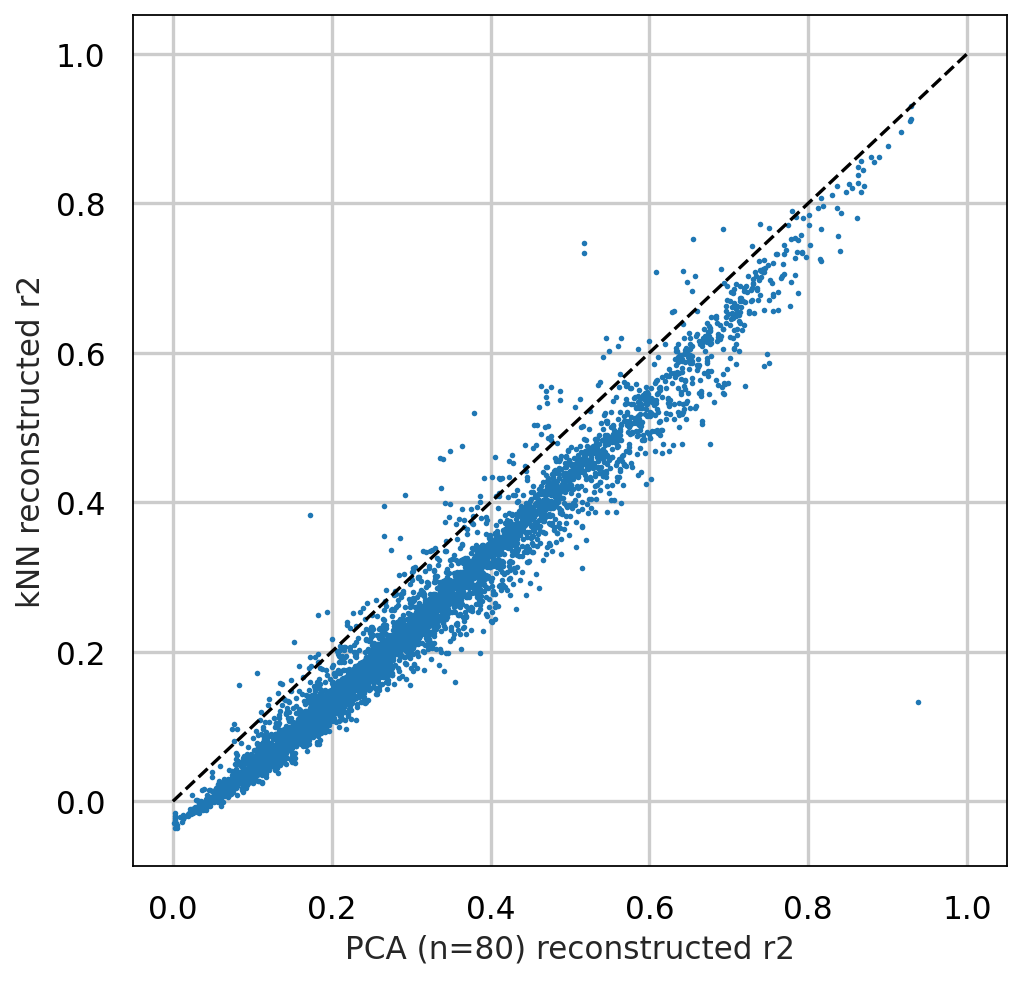

In [24]:
fig, ax = plt.subplots()
ax.plot([0,1],[0,1], '--k')
ax.scatter(r2genes, r2genes_knn, s=1, rasterized=True)
ax.set_xlabel('PCA (n=80) reconstructed r2')
ax.set_ylabel('kNN reconstructed r2')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'recon_pca_vs_knn.pdf'))
plt.show()

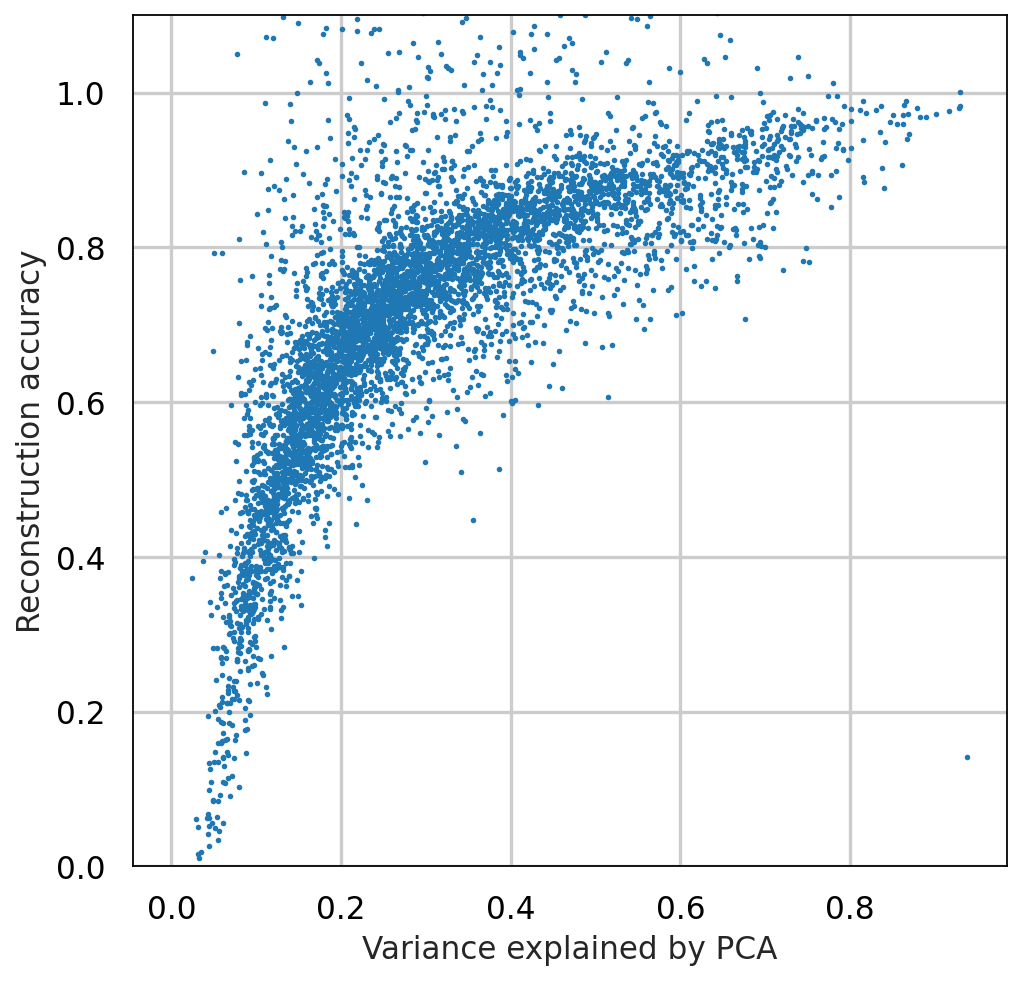

In [25]:
fig, ax = plt.subplots()
ax.scatter(r2genes, r2genes_knn/r2genes, s=1, rasterized=True)
ax.set_xlabel('Variance explained by PCA')
ax.set_ylabel('Reconstruction accuracy')
ax.set_ylim(ymin=0, ymax=1.1)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'recon_acc_vs_knn.pdf'))
plt.show()

In [26]:
# r2, varr[:npc].sum(), r2/varr[:npc].sum()

In [27]:
# choose a few genes for dredFISH and compare to Allen

In [28]:
genes = ref_data_genes.var.index.values

In [29]:
genes[np.argsort(r2genes_knn)]

array(['1810034E14Rik', 'Muc20', 'Gm3448', ..., 'Stmn3', 'Slc32a1',
       'Trbc2'], dtype=object)

In [30]:
genes[np.argsort(r2genes_knn)[::-1]]

array(['Trbc2', 'Slc32a1', 'Stmn3', ..., 'Gm3448', 'Muc20',
       '1810034E14Rik'], dtype=object)

In [31]:
genes[np.argsort(r2genes_knn)[::-1]][:10]

array(['Trbc2', 'Slc32a1', 'Stmn3', 'Neurod6', 'Bex2', 'Lhx6', 'Itpka',
       'Rprml', 'Dlx1', 'Tmem59l'], dtype=object)

- Slc32a1 (GABA vesicular transporter)
https://mouse.brain-map.org/experiment/siv?id=72081554&imageId=71974844&initImage=ish&contrast=0.5,0.5,0,255,4

- Stmn3
https://mouse.brain-map.org/experiment/siv?id=1003&imageId=101944049&initImage=ish&contrast=0.5,0.5,0,255,4

- Neurod6 (Hippo CA1 and CA3 - a bit cortex) https://mouse.brain-map.org/experiment/siv?id=698&imageId=101342437&initImage=ish&contrast=0.5,0.5,0,255,4

- Lhx6 https://mouse.brain-map.org/experiment/siv?id=635&imageId=101324452&initImage=ish&contrast=0.5,0.5,0,255,4

- Itpka (Pan-excitatory) https://mouse.brain-map.org/experiment/siv?id=79589520&imageId=79595125&initImage=ish&contrast=0.5,0.5,0,255,4

- Dlx1 https://mouse.brain-map.org/experiment/siv?id=348&imageId=101321278&initImage=ish&contrast=0.5,0.5,0,255,4

In [32]:
# get the NN genes
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference' + '/10X/genes.npy' 
tenx_genes = np.load(f)
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference' + '/SmartSeq/genes.npy' 
smrt_genes = np.load(f)
assert np.all(tenx_genes == smrt_genes)
nn_genes = tenx_genes

# intersect with this one n=3315
genesub = np.intersect1d(nn_genes, genes)
genesub_idx = basicu.get_index_from_array(genes, genesub)
print(nn_genes.shape, genes.shape, genesub.shape)
print(len(genesub))
genesub_idx

(10861,) (5576,) (3315,)
3315


array([   0,    6,   11, ..., 5568, 5573, 5574])

In [34]:
genesub_score = r2genes_knn[genesub_idx]

genesub_orderidx = np.argsort(genesub_score)[::-1]
genesub_order = genesub[genesub_orderidx]
genesub_score_order = genesub_score[genesub_orderidx]
print(genesub_order, genesub_score_order)

['Stmn3' 'Neurod6' 'Bex2' ... 'Cd27' 'Tmprss9' 'Muc20'] [ 0.9131042   0.91028497  0.8950625  ... -0.02211746 -0.02345535
 -0.03507646]


In [35]:
# get the top gene list
fout = os.path.join(dat_dir, 'rna', 'top_recon_genes_dpnmf_nn_n140.csv')
print(fout)

nnselection_cond = genesub_score_order > 0.6
outputgenes = genesub_order[nnselection_cond]
print(outputgenes, outputgenes.shape)

# # save
# pd.DataFrame(outputgenes).to_csv(fout, header=False, index=False)
# !head $fout
# !chmod 444 $fout

/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/top_recon_genes_dpnmf_nn_n140.csv
['Stmn3' 'Neurod6' 'Bex2' 'Lhx6' 'Dlx1' 'Tmem59l' 'Neurod2' 'Satb2'
 'Ptk2b' 'Rab3a' 'Uchl1' 'Gng3' 'Dnm1' 'Fezf2' 'Dlx5' 'Lingo1' 'Nfix'
 'Zfp36l1' 'Fxyd7' 'Scg5' 'Nxph3' 'Crym' 'Arx' 'Eno2' 'Nxph4' 'Ifitm3'
 'Fcrls' 'Zcchc12' 'Rab3b' 'Acot7' 'Cpne4' 'Kcnv1' 'Prkar1b' 'Atp1a1'
 'Cox6a2' 'Slc30a3' 'Igfbp6' 'Tagln3' 'Elmod1' 'Pnoc' 'Nsg1' 'Mllt11'
 'Chgb' 'Atp2b4' 'Btbd11' 'Arpp19' 'Ttc9b' 'Sez6' 'Hs3st2' 'Nefl' 'Snap47'
 'Hprt' 'Tesc' 'Pglyrp1' 'Atp6v1b2' 'Tac2' 'Cd63' 'Hsp90aa1' 'Syn1' 'Gli3'
 'Adora1' 'Lgals1' 'Got1' 'Arhgap25' 'Serp2' 'Syt5' 'Sox17' 'Stx1a'
 'Nr2f2' 'Dkkl1' 'Hpcal4' 'Prkcg' 'Rasgef1b' 'Dkk3' 'Cckbr' 'Bex1' 'Ngef'
 'Tceal3' 'Tspan13' 'Kcnip3' 'Dusp14' 'Fstl4' 'S100a16' 'Cfh' 'Osbpl1a'
 'Anxa3' 'Itpr1' 'Krt12' 'Pdzrn3' 'Gabrg2' 'Olfm2' 'Atp6v1c1' 'Pamr1'
 'Atp5b' 'Igsf21' 'Kctd4' 'Pgam1' 'Vcam1' 'Rbfox3' 'Tubb2a' 'Eno1'
 'Atp6v0e2' 'Tyro3' 'Atp5g3' 'Stmn4' 'Tuba4a' 'Cend1' '

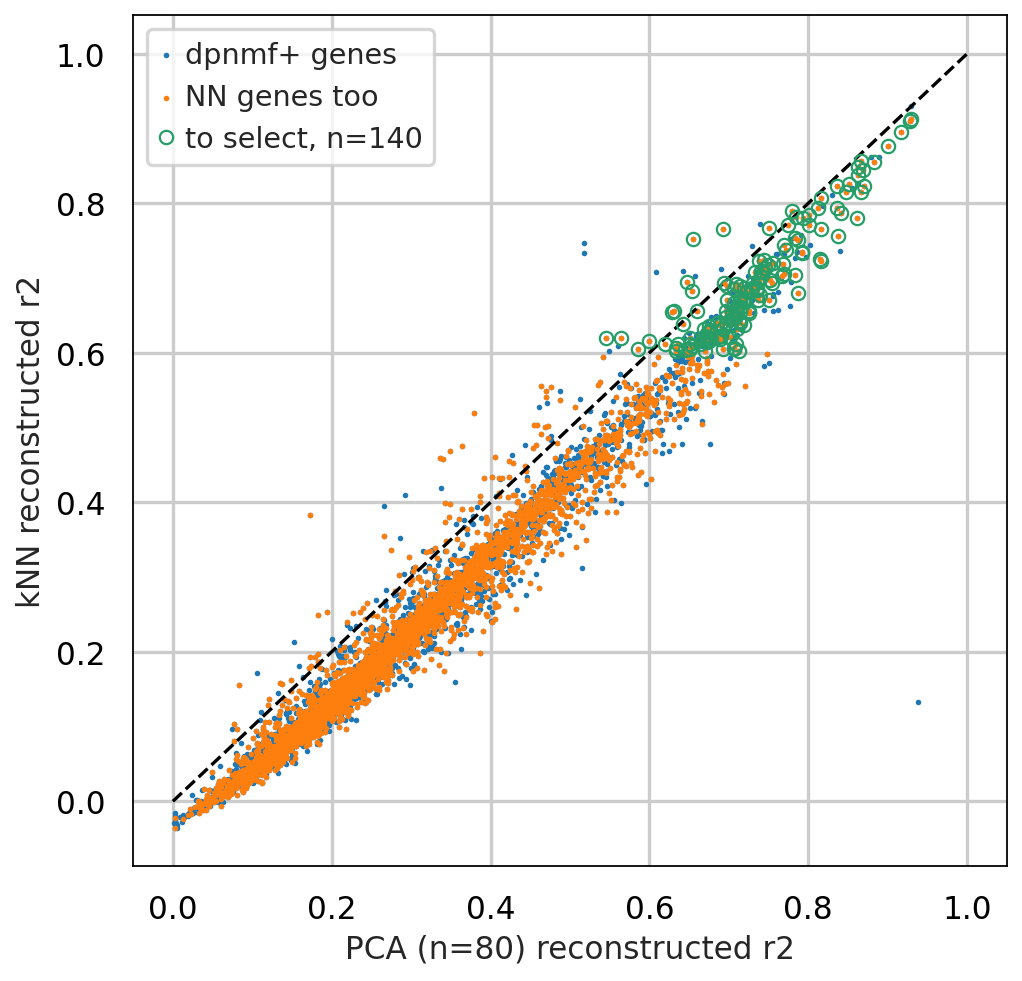

In [36]:
selection_cond = genesub_score>0.6

fig, ax = plt.subplots()
ax.plot([0,1],[0,1], '--k')
ax.scatter(r2genes, r2genes_knn, s=1, rasterized=True, label='dpnmf+ genes')
ax.scatter(r2genes[genesub_idx], r2genes_knn[genesub_idx], s=1, rasterized=True, label='NN genes too')
ax.plot(r2genes[genesub_idx][selection_cond], 
        r2genes_knn[genesub_idx][selection_cond], 
        'o',
        color='C2',
        fillstyle='none', 
        # s=1, 
        rasterized=True, label=f'to select, n={selection_cond.sum()}')
ax.set_xlabel('PCA (n=80) reconstructed r2')
ax.set_ylabel('kNN reconstructed r2')
ax.legend()
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'recon_pca_vs_knn.pdf'))
plt.show()

In [ ]:
# engineer the nn code to ignore the gene input